# RAT response analysis and filtering

This notebook processes model outputs saved as a timestamp-named directory. The first part of the notebook reads the inputs, prints the statistics on accuracies, solution rates and confidence intervals. The second part filters the responses based different matrices and creates distribution plots which show how well each method matches the human data.

To fully run the notebook, it is necessary to posses the human data, which we are not publishing because it is not ours. The first part of the notebook can be run without the data, as human accuracy rates have been published. To run the model with these accuracy rates, appropriate flag has to be set in the code. The second part of the notebook (distribution of responses) requires human data.

In [1]:
%matplotlib inline

In [2]:
from __future__ import absolute_import, division, print_function

from difflib import get_close_matches
import os
import pickle
import re
import warnings

import pytry
import matplotlib.pyplot as plt
import nengo
from nengo import spa
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns

from helper import *
from sparat.model.model import sanitize
from sparat.data_processing.generate_association_matrix import load_assoc_mat

IOError: [Errno 2] No such file or directory: '../data/associationmatrices/freeassoc_asymmetric.npy'

In [3]:
fig_path = '../txt/frontiers-paper/figures/'

In [4]:
sns.set('paper', 'ticks', 'Set1')

# Load necessary data

### RAT problems

In [5]:
problems_dir = os.path.join(os.curdir, os.pardir, 'data', 'rat', '25_problems_smith.csv')
prob = pd.read_csv(problems_dir, header=None, delimiter=' ', index_col=0, names=[u'cue1', u'cue2', u'cue3', u'solution'])

cues = zip(prob.cue1.values, prob.cue2.values, prob.cue3.values)
solutions = prob.solution.values

In [6]:
prob

,cue1,cue2,cue3,solution
1,DEMON,LIMIT,WAY,SPEED
2,WIDOW,BITE,MONKEY,SPIDER
3,TIME,HAIR,STRETCH,LONG
4,CHEST,CAR,STORE,TOY
5,LAND,HAND,HOUSE,FARM
6,DATE,ALLEY,FOLD,BLIND
7,BUMP,EGG,STEP,GOOSE
8,HIGH,BOOK,SOUR,NOTE
9,BROKEN,CLEAR,EYE,GLASS
10,COIN,QUICK,SPOON,SILVER


### Association matrices

In [7]:
mat_labs = []
assoc_mat, sim_mat = {}, {}

for mat_l in ['freeassoc_symmetric', 'google_symmetric']:
    mat, i2w, w2i = load_assoc_mat(assoc_dir, mat_l)
    np.fill_diagonal(mat, 0.)

    # regular matrix
    assoc_mat[mat_l] = mat
    sim_mat[mat_l] = np.zeros((len(prob), len(assoc)))
    
    # binary version
    bmat = 'binary_' + mat_l
    assoc_mat[bmat] = np.where(mat > 0, 1, 0)
    sim_mat[bmat] = np.zeros((len(prob), len(assoc)))
    mat_labs.extend([mat_l, bmat])

Similarity between the three cues and the target, used to determine a maximal threshold value required for filtering such that all solution words pass the filter.

In [8]:
def get_threshold(matrix, print_debug=False):
    similarities = np.zeros(len(prob))
    for i, row in prob.iterrows():
        c1, c2, c3, s = row.cue1, row.cue2, row.cue3, row.solution
        sol_str = matrix[w2i[s], [w2i[c1],w2i[c2],w2i[c3]]]        
        similarities[i-1] = sol_str.sum()
    return similarities
    
for mat_l in mat_labs:
    print('Maximal threshold for {0}: {1:.4f} '.format(mat_l, get_threshold(assoc_mat[mat_l]).min()))

Maximal threshold for freeassoc_symmetric: 0.0065 
Maximal threshold for binary_freeassoc_symmetric: 1.0000 
Maximal threshold for google_symmetric: 0.0062 
Maximal threshold for binary_google_symmetric: 3.0000 


Number of pairs which exist in free associations, but don't exist in n-gram data, and the other way around:

In [9]:
if 0:  # commented as it can take some time on slower machines
    idx_norms = np.where(assoc_mat['freeassoc_symmetric'].flatten() > 0)[0]
    idx_ngrams = np.where(assoc_mat['google_symmetric'].flatten() > 0)[0]

    print('Number of associations in FAN and not in n-gram:', len(set(idx_norms)-set(idx_ngrams)))
    print('Number of associations in Ngram and not in FAN:', len(set(idx_ngrams)- set(idx_norms)))

## Response filtering functions 

Use different association measures to filter responses from simulations. A good matrix should:

a) keep correct responses if they were produced in the simulation

b) match the human statistic on response lengths

c) approximately replicate exponential distribution of response lengths

Transformation matrix computed based on an association matrix, used to derive association-based vector representations:

To filter words which qualify as valid responses to the problem, we establish a selection criterion for the search process. That is, a word will be regarded as a response only if the distance between that word and the cue words is below a certain value.

In [10]:
for i, (cue, sol) in enumerate(zip(cues, solutions)):
    c1, c2, c3 = cue[0], cue[1], cue[2]
    c_idx = [w2i[c1], w2i[c2], w2i[c3]]
    
    for mat_l in mat_labs:
        sim_mat[mat_l][i] = assoc_mat[mat_l][c_idx].sum(axis=0)
        assert sim_mat[mat_l].sum() > 0

In [11]:
ms = '_'  # missing data

Load raw simulation data and human data:

In [12]:
def compound_solution(row):
    cues = row.cue1, row.cue2, row.cue3
    sol = row.solution
    new_r = []
    replace = False
    for r in row.responses:
        if r in map(lambda x: x+sol, cues) or r in map(lambda x: sol+x, cues):
            new_r.append(sol)
            replace = True
            break
        else:
            new_r.append(r)
    
    return new_r

In [13]:
def cut_responses_after_th(row, th):
    ok_idx = np.array(row.timings[:len(row.responses)]) < th    
    row['responses'] = list(np.array(row.responses)[ok_idx])
    row['correct'] = row.solution in row.responses
    return row

In [14]:
def filter_row(x, sims, th):        
    ok = []
    for r in x.responses:
        try:
            word = w2i[r]
        except KeyError:
            cand = get_close_matches(r, w2i)
            if len(cand) == 0:
                word = '_'
            else:
                word = w2i[cand[0]]
                
        if word == '_' or sims[x.prob_id-1, word] >= th:
            ok.append(r)
            
        if r == x.solution:
            break
    chain = ','.join(ok)
    return chain

In [15]:
def accuracy(d, num_el=None):
    corr = d.groupby('prob_id').sum()
    counts = d['prob_id'].value_counts()
    index, vals = counts.index.values, counts.values
    denom = vals[np.argsort(index)]
    if num_el is not None:
        denom = num_el
    p = corr.values.reshape(-1)/denom
    return 100*p

def print_stats(data, label='before'):
    lengths = data.responses.apply(lambda x: len(x)).values
    nr_cor = len(data.query('correct==True'))

    print('Shortest response {0} filter: {1}'.format(label, lengths.min()))
    print('Longest response {0}: {1}'.format(label,lengths.max()) )
    print('Average response length {0} filtering: {1:.2f}'.format(label, np.mean(lengths)))
    print('Correct response rate {0} filtering: {1:.2f}%'.format(label, 100.*nr_cor/len(data)))

In [16]:
def replace_cues(x, ms='_'):
    out = [ms if r in (x.cue1, x.cue2, x.cue3) else r for r in x.responses]
    return out        

In [17]:
def filter_responses(data, sims, th, method, plot=False, apply_filter=True):
    df_res = data.copy(deep=True)

    if apply_filter:
        df_res['responses'] = df_res.apply(lambda x: filter_row(x, sims, th=th), axis=1)
        df_res['responses'] = df_res['responses'].apply(lambda x: [i for i in x.split(',')])
    
        # update solutions as the correct responses might have been removed in filtering    
        df_res['correct'] = df_res.apply(lambda x: x.solution in x.responses, axis=1)    
        df_res['responses'] = df_res[['cue1', 'cue2', 'cue3', 'responses']].apply(lambda x: replace_cues(x), axis=1)
    
    lengths = df_res.responses.apply(lambda x: len(x)).values
    human_lengths = np.sort(human.responses.apply(lambda x: len(x)).values)

    bins = np.arange(0, 51)
    if plot:
        plt.figure()
        n1, bins1, _ = plt.hist(human_lengths, bins=bins, color='r', alpha=0.5, normed=True, label='Human')
        n2, bins2, _ = plt.hist(lengths, bins=bins, normed=True, alpha=0.5, label='Model', color='b')
        plt.xlabel('Response length')
        plt.ylabel('Normalized response length count')
        plt.title(method)
        plt.legend()      
        print("Resp length distr: r={:.2f} p={:.3f}".format(*pearsonr(n1, n2)))
        plt.show()            

    return df_res

## Load simulation data 

In [18]:
fname = 'simulations'   # name of the directory with model outputs
data_dir = os.path.join(os.curdir, os.pardir, 'sparat', 'model', 'data')
raw_data = pytry.read(path=os.path.join(data_dir, fname))

cols_in = ['_prob_id', '_cue1', '_cue2', '_cue3', '_solution', 'correct', 'responses', 'timings']
cols_out = ['prob_id', 'cue1', 'cue2', 'cue3', 'solution', 'correct', 'responses', 'timings']

sim_data = pd.DataFrame(raw_data, columns=cols_in)
sim_data.rename(columns=dict(zip(cols_in, cols_out)), inplace=True)

sim_data['responses'] = sim_data.apply(lambda x: compound_solution(x), axis='columns')
sim_data = sim_data.apply(lambda x: cut_responses_after_th(x, th=5), axis='columns')

model = accuracy(sim_data)

## Load human data (if exists)

If the pickled file with human responses doesn't exist, just load list of accuracies published in the supplementary material:

In [19]:
h_path = os.path.join(os.curdir, os.pardir, 'data', 'responses', 'pandas_human_responses_all.pkl')
if os.path.exists(h_path):
    human = pd.read_pickle(h_path)
    human['responses'] = human['responses'].apply(func=lambda x: [y.upper() for y in x])
    human['solution'] = human['solution'].apply(func=lambda x: x.upper())
    print('Nr human trials vs. nr model trials:', len(human), len(sim_data))
    ground = accuracy(human, num_el=56.)
else:
    human = np.array([
         48.2,  62.5,  32.1,  12.5,  10.7,  58.9,   8.9,  10.7,  48.2,
         50. ,  39.3,  30.4,  42.9,  26.8,  23.2,  42.9,  26.8,  58.9,
         85.7,  58.9,  75. ,  75. ,  14.3,  71.4,  42.9])
    ground = human

Nr human trials vs. nr model trials: 1396 1400


In [20]:
print_stats(sim_data)

Shortest response before filter: 2
Longest response before: 46
Average response length before filtering: 40.20
Correct response rate before filtering: 42.57%


In [21]:
if os.path.exists(h_path):
    print_stats(human)
else:
    print('Correct responses {:.2f}%'.format(human.mean()))

Shortest response before filter: 1
Longest response before: 49
Average response length before filtering: 7.78
Correct response rate before filtering: 42.41%


Number of participants/model runs solving each problem (the hardest and the easiest problem):

In [22]:
print('Easiest problem solved in:', sim_data.groupby('prob_id').sum().values.max(), ' runs (humans, n=48)')
print('Hardest problem solved in:', sim_data.groupby('prob_id').sum().values.min(), ' runs (humans, n=5)')

Easiest problem solved in: 37.0  runs (humans, n=48)
Hardest problem solved in: 2.0  runs (humans, n=5)


# Part 1: Accuracy stats

In [23]:
print('Model accuracy: {0:.2f}% (r={1:.2f}, p={2:.3f}) '.format(np.mean(model), *pearsonr(model, ground)))

Model accuracy: 42.57% (r=0.49, p=0.013) 


In [24]:
th = 30
print('Problems easier for the humans (diff above {}%)'.format(th))

idx = np.where((ground-model) > th)[0]
#print ground[idx], model[idx]
print(prob.loc[idx], ground[idx]-model[idx])

print('\nProblems easier for the model (diff above {}%)'.format(th))

idx = np.where((model-ground) > th)[0]
#print model[idx], ground[idx]
print(prob.loc[idx], model[idx]-ground[idx])

Problems easier for the humans (diff above 30%)
      cue1     cue2   cue3 solution
21  SAFETY  CUSHION  POINT      PIN [ 37.5]

Problems easier for the model (diff above 30%)
     cue1    cue2    cue3 solution
14  SPEAK   MONEY  STREET     EASY
22   DUST  CEREAL    FISH     BOWL [ 37.5         39.28571429]


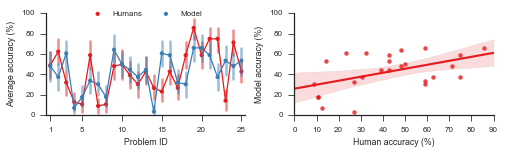

In [25]:
if os.path.exists(h_path):
    data_all = pd.concat([human, sim_data], ignore_index=True)
    data_all['Source'] = data_all.apply(lambda x: 'Humans' if x.timings is np.nan else 'Model', axis=1)
    data_all.rename(columns={'prob_id':'Problem ID'}, inplace=True)

    dat = data_all.groupby(['Problem ID', 'Source']).sum().unstack().correct
    dat['Humans'] = dat.Humans.apply(lambda x: 100*x/56.)          # divided by the nubmer of participants
    dat['Model'] = model

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18 / 2.54, 18 / 2.54 / 1.6 / 2.))
    ax = sns.pointplot(x="Problem ID", y="correct", hue="Source", data=data_all,
                       ci=95, ax=ax1, scale=0.5,
                       estimator=lambda x: 100*np.mean(x))
    for line in ax.lines:
        xdata = line.get_xdata()
        if len(xdata) == 2 and xdata[0] == xdata[1]:
            line.set_alpha(0.5)

    ax.xaxis.set_ticks([0] + range(4, 25, 5))
    ax.xaxis.set_ticklabels([1] + [x for x in range(5, 26, 5)])
    ax.set_ylabel('Average accuracy (%)')
    ax.set_ylim(0, 100)
    lg = ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.1))

    axr = sns.regplot(x="Humans", y="Model", data=dat, ax=ax2, label='RAT problem', ci=95)
    axr.set_ylabel('Model accuracy (%)')
    axr.set_xlabel('Human accuracy (%)')
    axr.set_ylim(0, 100)

    sns.despine()
    plt.tight_layout()
    if 0:
        plt.savefig(fig_path + 'accuracies.pdf', bbox_inches='tight', dpi=300)
else:
    plt.figure(figsize=(12, 3))
    plt.subplot(121)
    plt.plot(model, label='Model', marker='o')
    plt.plot(ground, label='Humans', marker='o')
    plt.xlabel('Problem ID')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.subplot(122)
    plt.scatter(ground, model)
    plt.xlabel('Human accuracy')
    plt.ylabel('Model accuracy')

Comparing accuracies for matrices with less associations, where in th_x x refers to percentage in (tens) of associations removed from the association matrix:

In [26]:
names = ['th_06', 'th_07', 'th_08']

for i, name in enumerate(names):
    sim = pd.DataFrame(pytry.read(path=os.path.join(data_dir, name)), columns=cols_in)
    sim.rename(columns=dict(zip(cols_in, cols_out)), inplace=True)
    
    sim['responses'] = sim.apply(lambda x: compound_solution(x), axis='columns')
    sim = sim.apply(lambda x: cut_responses_after_th(x, th=5), axis='columns')    
    print(name, np.mean(accuracy(sim)))

th_06 43.4
th_07 41.8666666667
th_08 42.2857142857


In [27]:
ci_low = lambda p, n: p - 1.96*np.sqrt((p/n)*(1-p))
ci_high = lambda p, n: p + 1.96*np.sqrt((p/n)*(1-p))

Number of problems where there was no significant difference in accuracies:

In [28]:
low, high = ci_low(ground/100., 56), ci_high(ground/100., 56)

In [29]:
m_low, m_high = ci_low(model/100, 56.), ci_high(model/100, 56.)
h_low, h_high = ci_low(ground/100, 56.), ci_high(ground/100., 56)

In [30]:
within_ci = 0
for i in range(len(m_low)):
    ml, mh, hl, hh = m_low[i], m_high[i], h_low[i], h_high[i]
    if (ml <= hl <= mh and hh >= mh) or (hl <= ml <= hh and mh >= hh):
        within_ci += 1
print('Overlap in CIs:', within_ci)

Overlap in CIs: 18


# Part 2: Response filtering

This part requires human data.

Stats for the raw model output (method doesn't ather as apply_filter is set to False):

Resp length distr: r=-0.30 p=0.032


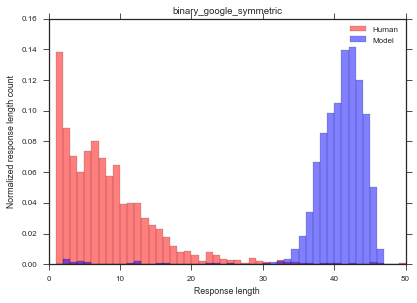

Shortest response after filter: 2
Longest response after: 46
Average response length after filtering: 40.20
Correct response rate after filtering: 42.57%


In [31]:
mat_l = 'binary_google_symmetric' 
filtered = filter_responses(sim_data, sims=sim_mat[mat_l], th=1, method=mat_l, plot=True, apply_filter=False)
print_stats(filtered, 'after')

Resp length distr: r=0.54 p=0.000


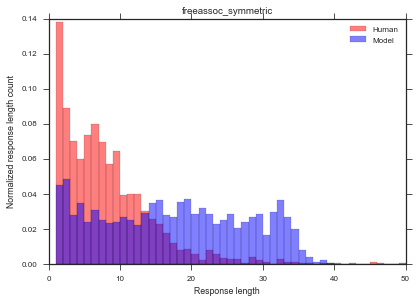

Shortest response after filter: 1
Longest response after: 39
Average response length after filtering: 16.99
Correct response rate after filtering: 42.57%
freeassoc_symmetric Throwing away 57.73% responses
---
Resp length distr: r=0.51 p=0.000


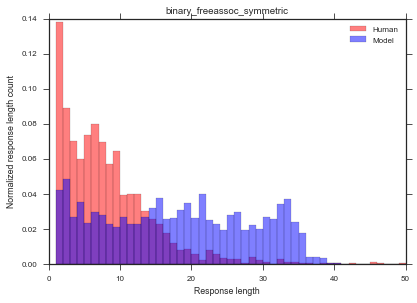

Shortest response after filter: 1
Longest response after: 40
Average response length after filtering: 17.47
Correct response rate after filtering: 42.57%
binary_freeassoc_symmetric Throwing away 56.53% responses
---
Resp length distr: r=0.96 p=0.000


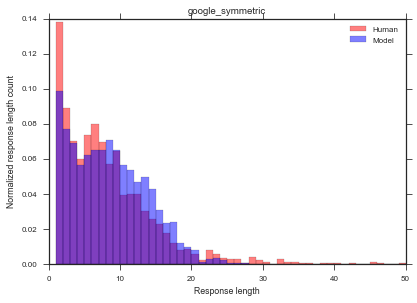

Shortest response after filter: 1
Longest response after: 27
Average response length after filtering: 8.06
Correct response rate after filtering: 42.57%
google_symmetric Throwing away 79.95% responses
---
Resp length distr: r=0.93 p=0.000


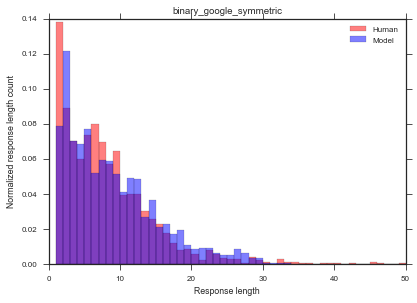

Shortest response after filter: 1
Longest response after: 33
Average response length after filtering: 8.44
Correct response rate after filtering: 42.57%
binary_google_symmetric Throwing away 79.01% responses
---


In [32]:
filtered_df = {}
l1 = np.sum(sim_data.responses.apply(lambda x: len(x)))

for mat_l in mat_labs:
    th = 3 if 'binary' in mat_l else 0.006
    if 'binary_freeassoc' in mat_l:
        th = 1
    filtered_df[mat_l] = filter_responses(sim_data, sims=sim_mat[mat_l], th=th, method=mat_l, plot=True)
    print_stats(filtered_df[mat_l], 'after')
    l2 = np.sum(filtered_df[mat_l].responses.apply(lambda x: len(x)))
    print('{} Throwing away {:.2f}% responses'.format(mat_l, 100*(1-float(l2)/l1)))
    print('---')

Resp length distr: r=0.36 p=0.010


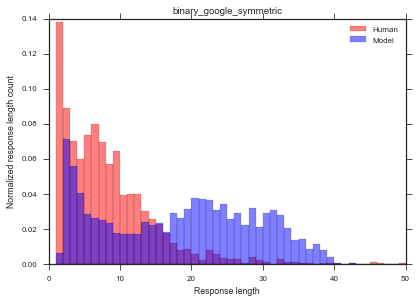

Shortest response after filter: 1
Longest response after: 33
Average response length after filtering: 8.44
Correct response rate after filtering: 42.57%


In [33]:
mat_l = 'binary_google_symmetric'
filter_responses(sim_data, sims=sim_mat[mat_l], th=2, method=mat_l, plot=True)
print_stats(filtered_df[mat_l], 'after')

In [34]:
f_lengths = lambda x: x.responses.apply(lambda x: len(x))

human_lengths = f_lengths(human)
model_lengths = [f_lengths(filtered_df[lab]) for lab in mat_labs]

### Saving filtered responses for analysis

This saves a csv file in the data/simulations directory. 'f' is prepended to the name to indicate filtered simulation responses:

In [35]:
method = 'binary_google_symmetric'
final = filtered_df[method].copy(deep=True)
for xup in ['cue1', 'cue2', 'cue3', 'solution']:
    final[xup] = final.apply(func=lambda x: x[xup].upper(), axis=1)

final['responses'] = final['responses'].apply(lambda x: ",".join(x))

# if no responses given, replace responses with the missing symbol
l_resp = final.apply(lambda x: len(x.responses), axis=1).values
zero_l = np.where(l_resp < 1)[0]
final.loc[zero_l, 'responses'] = '_'

assert final.responses.apply(lambda x: len(x)).values.min() > 0

# save simulation resutls
datapath = os.path.join(os.curdir, os.pardir, 'data', 'responses')

# indicate that responses have been filtered by prepending 'f'
save_name = 'f' + method + '_' + fname + '.csv'
if not os.path.exists(datapath):
    os.makedirs(datapath)

final.to_csv(os.path.join(datapath, save_name), index=False)
print('Saved to:', datapath, 'as', save_name)

Saved to: ./../data/responses as fbinary_google_symmetric_simulations.csv


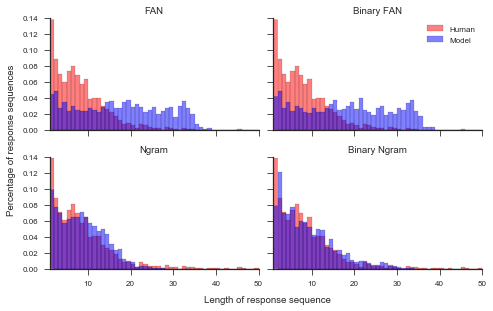

In [36]:
bins = np.arange(1, 51)
alpha = 0.5

fig, (ax1, ax2) = plt.subplots(2,2, sharey=True, sharex=True, figsize=(18 / 2.54, 18 / 2.54 / 1.6))
axes = [ax1, ax2]
labs = ['FAN', 'Binary FAN', 'Ngram', 'Binary Ngram']

k = 0
for i in [0, 1]:
    for j in [0, 1]:        
        sns.distplot(human_lengths, bins=bins, color='r', label='Human', kde=False, norm_hist=True, 
                      ax=axes[i][j], axlabel=False, hist_kws={"alpha":alpha})
        g = sns.distplot(model_lengths[k], bins=bins, color='b', label='Model', kde=False, norm_hist=True, 
                      ax=axes[i][j], axlabel=False, hist_kws={"alpha":alpha})
        g.set_title(labs[k])
        g.set_xlim(left=1)
        if mat_labs[k] == 'binary_freeassoc_symmetric':
            axes[i][j].legend()
        k+=1

fig.text(0.55, 0.04, 'Length of response sequence', ha='center')
fig.text(0.04, 0.55, 'Percentage of response sequences', va='center', rotation='vertical')

sns.despine()
plt.tight_layout(rect=(0.05, 0.05, 1, 1))
if 0:
    plt.savefig(fig_path + 'filters.pdf', bbox_inches='tight', dpi=300)

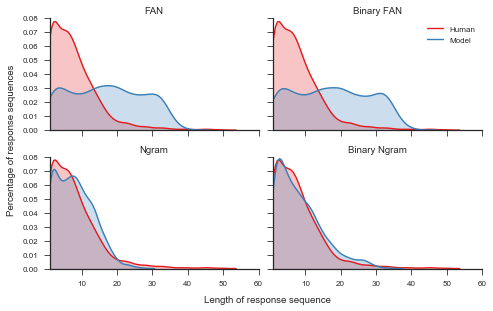

In [37]:
bins = np.arange(1, 51)

fig, (ax1, ax2) = plt.subplots(2,2, sharey=True, sharex=True, figsize=(18 / 2.54, 18 / 2.54 / 1.6))
axes = [ax1, ax2]
labs = ['FAN', 'Binary FAN', 'Ngram', 'Binary Ngram']

k = 0
for i in [0, 1]:
    for j in [0, 1]:        
        sns.kdeplot(human_lengths, label='Human', shade=True, ax=axes[i][j], legend=False)
        g = sns.kdeplot(model_lengths[k], label='Model', shade=True, ax=axes[i][j], legend=False)
        g.set_title(labs[k])
        g.set_xlim(left=1)
        if mat_labs[k] == 'binary_freeassoc_symmetric':
            axes[i][j].legend()
        k+=1

fig.text(0.55, 0.04, 'Length of response sequence', ha='center')
fig.text(0.04, 0.55, 'Percentage of response sequences', va='center', rotation='vertical')

sns.despine()
plt.tight_layout(rect=(0.05, 0.05, 1, 1))
if 0:
    plt.savefig(fig_path + 'filters_kde.pdf', bbox_inches='tight', dpi=300)